In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.model_selection import train_test_split

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../HSG Historical Data.csv')

In [3]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [4]:
tranformData(df)

In [5]:
#Định dạng lại cột Date từ obj -> datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
df.index = df.Date
df.drop('Date', axis=1, inplace=True)

In [6]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-12-01,13830.5,13772.9,13917.0,13657.6,4410000.0,0.0084
2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,0.0688
2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-0.0175
2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,0.0258
2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-0.0155
...,...,...,...,...,...,...
2023-05-29,15700.0,15500.0,15700.0,15350.0,9600000.0,0.0228
2023-05-30,15850.0,15800.0,16000.0,15600.0,13350000.0,0.0096
2023-05-31,15400.0,15800.0,15850.0,15200.0,36230000.0,-0.0284


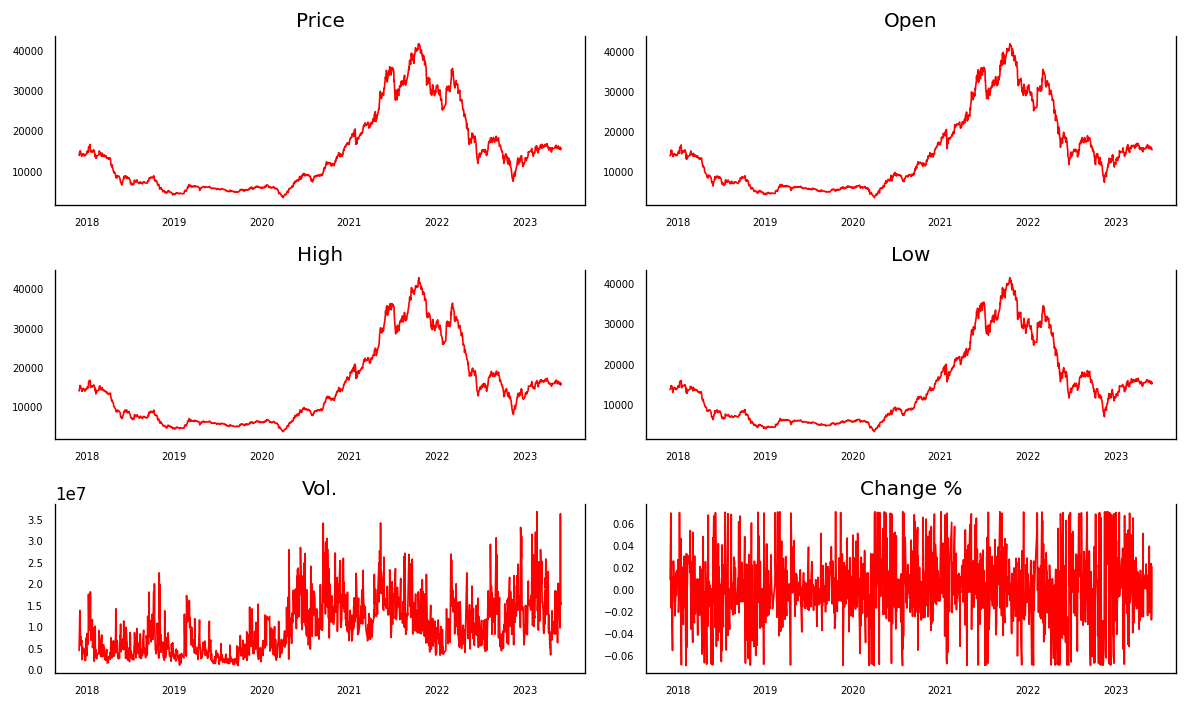

In [7]:


# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
     

In [8]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Price_x,Open_x,High_x,Low_x,Vol._x,Change %_x
Price_y,1.0000,0.0001,0.0006,0.0000,0.0002,0.0128
Open_y,0.0000,1.0000,0.0000,0.0000,0.0001,0.0000
High_y,0.0000,0.0000,1.0000,0.0000,0.0012,0.0000
Low_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
Vol._y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
Change %_y,0.1397,0.3697,0.0382,0.3542,0.0077,1.0000


In [9]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  689.47    > 83.9383   =>   True
Open   ::  457.21    > 60.0627   =>   True
High   ::  249.81    > 40.1749   =>   True
Low    ::  94.7      > 24.2761   =>   True
Vol.   ::  26.96     > 12.3212   =>   True
Change % ::  0.37      > 4.1296    =>   False


In [10]:
nobs=int(0.2*len(df))
n_train = int(0.6 * len(df))
n_test = int(0.2 * len(df))
n_validation = len(df) - n_train - n_test
nobs_val= n_validation
df_train = df[:n_train]
df_test = df[n_train:n_train+n_test]
df_validation = df[n_train+n_test:]

# Kiểm tra kích thước
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(822, 6)
(274, 6)
(275, 6)


In [11]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [12]:
# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.7106
 No. Lags Chosen       = 17
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.99. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.6165
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.988. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root

In [13]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [14]:
# ADF Test trên từng cột của DataFrame chứa sự khác biệt đầu tiên
for name in df_differenced.columns:
    adfuller_test(df_differenced[name], name=name)
    print('\n')


    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5569
 No. Lags Chosen       = 16
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5017
 No. Lags Chosen       = 19
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

    Augmented Dickey-Fuller Test on "Vol." 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.8466
 No. Lags Chosen       = 7
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Change %" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.0548
 No. Lags Chosen       = 17
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [15]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [16]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.3771
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.673
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.6813
 No. Lags Chosen       = 19
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.3627
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Vol." 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

In [17]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  66.58828394869226
BIC :  66.82972415812063
FPE :  8.297081632664122e+28
HQIC:  66.68093147471731 

Lag Order = 2
AIC :  64.87278805035145
BIC :  65.32160866435513
FPE :  1.4924536412821176e+28
HQIC:  65.04502334634874 

Lag Order = 3
AIC :  63.831400919125414
BIC :  64.48800172305937
FPE :  5.268015544693216e+27
HQIC:  64.08338663866563 

Lag Order = 4
AIC :  63.19901168104341
BIC :  64.06379373158828
FPE :  2.79918769066003e+27
HQIC:  63.53091100765904 

Lag Order = 5
AIC :  62.65190347352708
BIC :  63.72526910427898
FPE :  1.6198382206014824e+27
HQIC:  63.06388012307202 

Lag Order = 6
AIC :  62.36485897943706
BIC :  63.64721180652866
FPE :  1.2158429136890366e+27
HQIC:  62.85707720245938 

Lag Order = 7
AIC :  62.13667239833692
BIC :  63.6284173260901
FPE :  9.67991191340609e+26
HQIC:  62.70929698246509 

Lag Order = 8
AIC :  61.855271955424406
BIC :  63.55681518203467
FPE :  7.307786659856057e+26
HQIC:  62.50846822776699 

Lag Order = 9
AIC :  61.58287021323722

In [18]:
x = model.select_order(maxlags=10)
x.summary()

,AIC,BIC,FPE,HQIC
0,70.40,70.43,3.742e+30,70.41
1,66.56,66.81,8.094e+28,66.66
2,64.84,65.30,1.450e+28,65.02
3,63.80,64.46,5.116e+27,64.06
4,63.17,64.04,2.717e+27,63.50
5,62.65,63.72,1.610e+27,63.06
6,62.36,63.65,1.214e+27,62.86
7,62.13,63.63,9.663e+26,62.71
8,61.86,63.56,7.331e+26,62.51
9,61.59,63.50*,5.587e+26,62.32


In [19]:
model_fitted = model.fit(15)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Jun, 2023
Time:                     00:34:21
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    64.2555
Nobs:                     805.000    HQIC:                   62.2958
Log likelihood:          -30889.7    FPE:                3.36201e+26
AIC:                      61.0739    Det(Omega_mle):     1.76818e+26
--------------------------------------------------------------------
Results for equation Price
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.333065         9.385133            0.035           0.972
L1.Price            -0.868387         0.111433           -7.793           0.000
L1.Open              0.310158         0.102200            3.035 

In [20]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

15


array([[-1.2120e+03, -4.5470e+02, -9.0920e+02, -4.5460e+02,  4.3200e+06,
        -8.9700e-02],
       [ 2.2720e+02, -1.3256e+03, -1.8930e+02, -7.5760e+02,  1.5800e+06,
         7.1000e-02],
       [-4.5460e+02,  6.8170e+02,  2.6510e+02, -7.5700e+01,  6.8000e+05,
        -3.2200e-02],
       [ 4.9250e+02, -6.8170e+02, -8.3330e+02,  0.0000e+00, -3.3300e+06,
         4.4600e-02],
       [ 4.9250e+02,  9.8470e+02,  1.3637e+03,  6.4390e+02,  5.6300e+06,
         0.0000e+00],
       [-1.0986e+03, -4.9230e+02, -1.0986e+03, -2.2720e+02, -5.2200e+06,
        -7.4500e-02],
       [ 2.6520e+02, -2.6520e+02, -1.5150e+02, -7.9550e+02,  7.5000e+05,
         6.3300e-02],
       [ 4.1660e+02,  2.6520e+02,  5.6830e+02,  8.7120e+02,  1.4400e+06,
         7.6000e-03],
       [-4.5450e+02,  7.5700e+01, -7.5900e+01, -2.2730e+02, -4.1000e+05,
        -4.0900e-02],
       [ 1.5160e+02, -2.6520e+02, -1.8930e+02, -1.5140e+02, -2.6000e+05,
         2.8300e-02],
       [ 1.5140e+02,  3.8000e+01,  7.5700e+01, -7.

In [21]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[n_train:n_train+n_test], columns=df.columns + '_2d')
df_forecast

,Price_2d,Open_2d,High_2d,Low_2d,Vol._2d,Change %_2d
Date,,,,,,
2021-03-23,99.342491,-449.834449,-236.471075,-117.941827,-2.685802e+06,0.040305
2021-03-24,49.814453,-414.437298,66.558450,-325.230320,9.997765e+06,-0.012735
2021-03-25,336.197172,366.247068,514.295762,336.184082,-2.920547e+06,0.014182
2021-03-26,-220.280723,502.333746,-142.802278,401.030257,-5.269475e+06,-0.031835
2021-03-29,-56.281588,-412.904941,-187.024142,-629.841562,7.568286e+06,0.019631
...,...,...,...,...,...,...
2022-04-20,0.036177,0.032829,0.031204,0.025154,-1.569127e+02,0.000001
2022-04-21,0.035980,0.032709,0.031033,0.024803,-1.588821e+02,0.000001
2022-04-22,0.036135,0.032662,0.031065,0.024798,-1.575896e+02,0.000002


In [22]:
# Forecast val
fc_val = model_fitted.forecast(y=forecast_input, steps=nobs_val)
df_forecast_val = pd.DataFrame(fc_val, index=df.index[n_train+n_test:], columns=df.columns + '_2d')
df_forecast_val

,Price_2d,Open_2d,High_2d,Low_2d,Vol._2d,Change %_2d
Date,,,,,,
2022-04-27,99.342491,-449.834449,-236.471075,-117.941827,-2.685802e+06,0.040305
2022-04-28,49.814453,-414.437298,66.558450,-325.230320,9.997765e+06,-0.012735
2022-04-29,336.197172,366.247068,514.295762,336.184082,-2.920547e+06,0.014182
2022-05-04,-220.280723,502.333746,-142.802278,401.030257,-5.269475e+06,-0.031835
2022-05-05,-56.281588,-412.904941,-187.024142,-629.841562,7.568286e+06,0.019631
...,...,...,...,...,...,...
2023-05-29,0.035980,0.032709,0.031033,0.024803,-1.588821e+02,0.000001
2023-05-30,0.036135,0.032662,0.031065,0.024798,-1.575896e+02,0.000002
2023-05-31,0.036366,0.032770,0.031235,0.025123,-1.555034e+02,0.000002


In [23]:
def invert_transformation(df_train, df_forecast_val, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc_val = df_forecast_val.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc_val[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc_val[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc_val[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc_val[str(col)+'_1d'].cumsum()
    return df_fc_val

In [24]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [25]:
df_results_val = invert_transformation(df_train, df_forecast_val, second_diff=True)        
df_results_val.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]

,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
Date,,,,,,
2022-04-27,21614.542491,22050.165551,21884.628925,21775.958173,9.241977e+05,0.002405
2022-04-28,21498.599434,21564.693804,21601.016300,21446.386027,4.816161e+06,0.004074
2022-04-29,21718.853549,21445.469125,21831.699437,21452.997962,5.787576e+06,0.019926
2022-05-04,21718.826942,21828.578192,21919.580295,21860.640154,1.489518e+06,0.003943
2022-05-05,21662.518746,21798.782318,21820.437012,21638.440785,4.759745e+06,0.007591
...,...,...,...,...,...,...
2023-05-29,27927.434139,28347.022512,24538.992485,32726.070875,-1.730369e+08,0.320261
2023-05-30,27955.629686,28376.014084,24553.166192,32770.741693,-1.737188e+08,0.321627
2023-05-31,27983.861600,28405.038425,24567.371134,32815.437634,-1.744007e+08,0.322995


In [26]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]

,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
Date,,,,,,
2021-03-23,21614.542491,22050.165551,21884.628925,21775.958173,9.241977e+05,0.002405
2021-03-24,21498.599434,21564.693804,21601.016300,21446.386027,4.816161e+06,0.004074
2021-03-25,21718.853549,21445.469125,21831.699437,21452.997962,5.787576e+06,0.019926
2021-03-26,21718.826942,21828.578192,21919.580295,21860.640154,1.489518e+06,0.003943
2021-03-29,21662.518746,21798.782318,21820.437012,21638.440785,4.759745e+06,0.007591
...,...,...,...,...,...,...
2022-04-20,27899.274727,28318.063603,24524.849842,32681.424855,-1.723553e+08,0.318896
2022-04-21,27927.434139,28347.022512,24538.992485,32726.070875,-1.730369e+08,0.320261
2022-04-22,27955.629686,28376.014084,24553.166192,32770.741693,-1.737188e+08,0.321627


In [27]:
# Chuyển đổi dự đoán về đơn vị ban đầu
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to the original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col) + '_1d'] = (df_train[col].iloc[-1] - df_train[col].iloc[-2]) + df_fc[col + '_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[col + '_1d'].cumsum()
    return df_fc

df_future_results = invert_transformation(df_train, df_future, second_diff=True)
df_future_results.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]


,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
0,21614.542491,22050.165551,21884.628925,21775.958173,9.241977e+05,0.002405
1,21498.599434,21564.693804,21601.016300,21446.386027,4.816161e+06,0.004074
2,21718.853549,21445.469125,21831.699437,21452.997962,5.787576e+06,0.019926
3,21718.826942,21828.578192,21919.580295,21860.640154,1.489518e+06,0.003943
4,21662.518746,21798.782318,21820.437012,21638.440785,4.759745e+06,0.007591
...,...,...,...,...,...,...
269,27899.274727,28318.063603,24524.849842,32681.424855,-1.723553e+08,0.318896
270,27927.434139,28347.022512,24538.992485,32726.070875,-1.730369e+08,0.320261
271,27955.629686,28376.014084,24553.166192,32770.741693,-1.737188e+08,0.321627
272,27983.861600,28405.038425,24567.371134,32815.437634,-1.744007e+08,0.322995


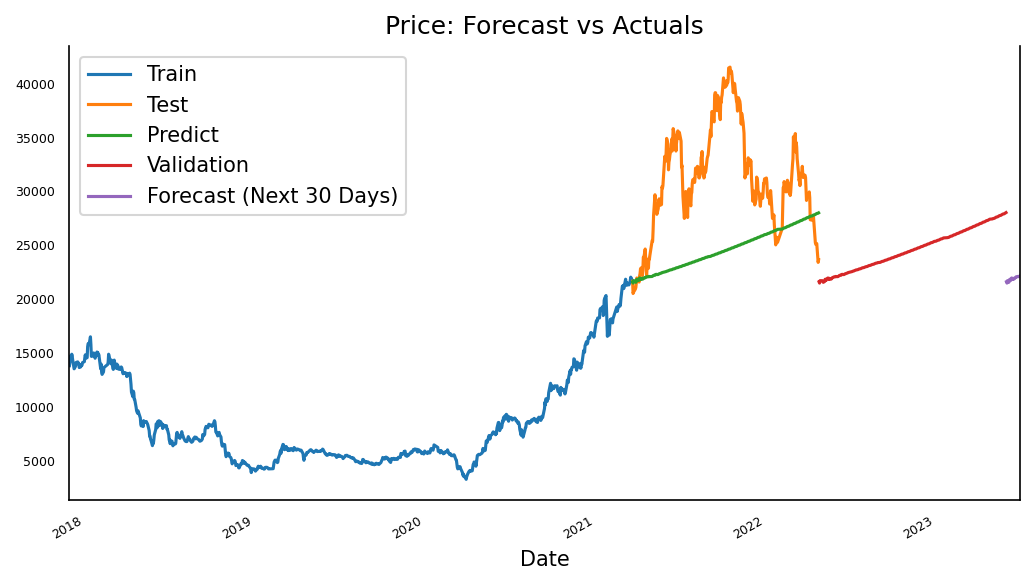

In [28]:
import datetime

# Sử dụng model_fitted để dự đoán 30 ngày tiếp theo
n_forecast_days = 30
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)

# Chuyển đổi dự đoán thành DataFrame
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

# Chuyển đổi dự đoán về đơn vị ban đầu
df_future_results = invert_transformation(df_train, df_future, second_diff=True)

# Tạo index cho 30 ngày tiếp theo
future_dates = pd.date_range(start=df.index[-1] + datetime.timedelta(days=1), periods=n_forecast_days, freq='D')

# Tạo DataFrame chứa dự đoán cho 30 ngày tiếp theo
df_future_forecast = pd.DataFrame(df_future_results.values, index=future_dates, columns=df_future_results.columns)

# Vẽ đồ thị
fig, ax = plt.subplots(dpi=150, figsize=(7, 4))

# Chọn cột dữ liệu cần vẽ
col = 'Price'

# Vẽ dữ liệu huấn luyện
df_train[col].plot(legend=True, ax=ax, label='Train')

# Vẽ dữ liệu kiểm tra
df_test[col][-nobs:].plot(legend=True, ax=ax, label='Test')

# Vẽ dự đoán trên tập huấn luyện
df_results[col+'_forecast'].plot(legend=True, ax=ax, label='Predict').autoscale(axis='x', tight=True)

# Vẽ dự đoán trên tập kiểm tra
df_results_val[col+'_forecast'].plot(legend=True, ax=ax, label='Validation').autoscale(axis='x', tight=True)

# Vẽ dự đoán cho 30 ngày tiếp theo
df_future_forecast[col + '_forecast'].plot(legend=True, ax=ax, label='Forecast (Next 30 Days)')

# Định dạng đồ thị và tiêu đề
ax.set_title(col + ": Forecast vs Actuals")
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=6)

plt.tight_layout()


In [29]:
def forecast_accuracy(forecast, actual):
    forecast = np.array(forecast)  # Chuyển đổi dự đoán thành numpy array
    actual = np.array(actual)  # Chuyển đổi dữ liệu thực tế thành numpy array
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return {'mape': mape, 'rmse': rmse, }


print('Forecast Accuracy of: Price')
accuracy_prod = forecast_accuracy(df_results['Price_forecast'].values, df_test['Price'])
for k, v in accuracy_prod.items():
    print(str.title(k), ': ', round(v, 4))



Forecast Accuracy of: Price
Mape :  0.2071
Rmse :  8411.2836
